In [0]:
import sklearn, torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [0]:
X_target, y_target = sklearn.datasets.make_blobs(n_samples=2000, n_features=2, centers = [[-3,-2], [3, 2]], cluster_std = 1)#[[-5, -5], [-10, 5], [10, -15], [5, 5], [15, 10], [2, 15]], cluster_std = 2.5)

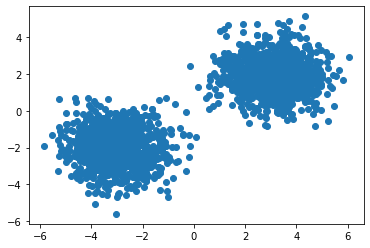

In [3]:
plt.scatter(X_target[:,0], X_target[:,1])

In [0]:
# # Change the labels to binary labels
# for ind, ele in enumerate(y_target):
#   if ele < 1:
#     y_target[ind] = 0
#   else:
#     y_target[ind] = 1

In [0]:
# Define the dataset class for a custom dataset
class CustomDataset(Dataset):
    
    def __init__(self, data_frame, transform=None):
        self.data = data_frame
        self.transform = transform
#         
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        obs = self.data.iloc[index, 0 : 2].values
        label = self.data.iloc[index, 2]
        
        if self.transform is not None:
            obs = self.transform(obs)
            
        return obs, label

Text(0, 0.5, 'feature 2')

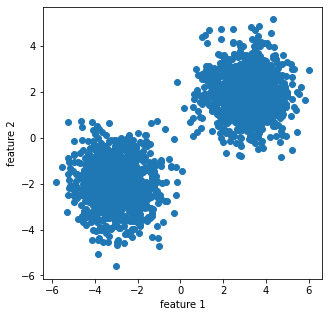

In [6]:
# Transforming the data into Pytorch format
data_target = pd.DataFrame({'X1' : X_target[:, 0].tolist(),
                   'X2' : X_target[:, 1].tolist(), 
                   'label' : y_target.tolist()})
# Plot the toy data
plt.figure(figsize = (5, 5))
plt.scatter(data_target['X1'], data_target['X2'])
plt.xlabel('feature 1')
plt.ylabel('feature 2')
# plt.xlim(-15, 15)
# plt.ylim(-15, 15)

In [0]:
target_dataset = CustomDataset(data_target, transform = None)
target_loader = torch.utils.data.DataLoader(target_dataset, batch_size = 16, shuffle = True, num_workers = 2)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class linear_model(nn.Module):
  def __init__(self):
    super(linear_model, self).__init__()
    self.fc11 = nn.Linear(2, 1)
    nn.init.xavier_normal_(self.fc11.weight)

  def forward(self, x_):
    x_ = x_.view(-1, 2)
    x1_ = torch.sigmoid(self.fc11(x_))  
    
    return x1_
  
model = linear_model()  

In [0]:
# Define loss function and optimizer
import torch.optim as optim

loss_function = nn.BCELoss(reduction = 'mean') # sums all outputs and divides by total data points

optimizer = optim.Adam(model.parameters(), lr = 0.1)

In [10]:
n_epochs = 10

for epochs in range(n_epochs):
 
  running_loss = 0
  
  for batch in target_loader:
    data, targets = batch

    optimizer.zero_grad()

    output = model(data.float()) 
    loss = loss_function(output, targets.view(-1, 1).float())
  
    loss.backward()

    optimizer.step()

    running_loss += loss.item()
  print(running_loss)

7.963366257026792
0.5267152148444438
0.3591843309986871
0.272402539732866
0.21835585784356226
0.18273051685537212
0.15720855207109707
0.13881100958360548
0.12403843113543189
0.11240023945993016


In [11]:
# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in target_loader:
    images, labels = data
    outputs = model(images.float())
#     _, predicted = torch.max(outputs, 1)
    predicted = outputs > 0.5
#     predicted = predicted.view(predicted.size(0))
    total += labels.size(0)
    matches = 0
    for i in range(len(predicted)):
      if predicted[i].item() == labels[i].item():
        matches += 1
    correct += matches#(predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

Accuracy of the network on the entire data set is : 100 %


In [12]:
# Save the idea weights (ideal for the target data)
w_star = model.fc11.weight
w_star

Parameter containing:
tensor([[2.6405, 2.6071]], requires_grad=True)

(-15.0, 15.0)

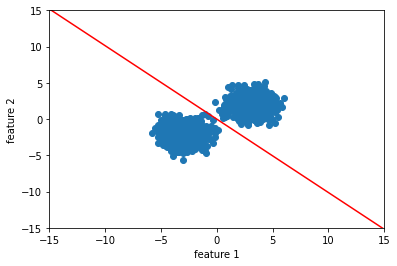

In [13]:
x_s1 = list(range(-20, 25, 5))
y_s1 = []
y_s2 = []
for el in x_s1:
  y_s1.append((-model.fc11.weight[0][0].item()/ model.fc11.weight[0][1].item()) * el)


plt.plot(x_s1, y_s1, color = 'red') 

plt.scatter(data_target['X1'], data_target['X2'])
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim(-15, 15)
plt.ylim(-15, 15)

In [0]:
def gram_schmidt(A):
    """Orthogonalize a set of vectors stored as the columns of matrix A."""
    # Get the number of vectors.
    n = A.shape[1]
    for j in range(n):
        # To orthogonalize the vector in column j with respect to the
        # previous vectors, subtract from it its projection onto
        # each of the previous vectors.
        for k in range(j):
            A[:, j] -= np.dot(A[:, k], A[:, j]) * A[:, k]
        A[:, j] = A[:, j] / np.linalg.norm(A[:, j])
    return A


In [0]:
w_star1 =  np.reshape(np.array(w_star.detach()), (-1, 1))

# Normalized w*
w_star1 = w_star1 / np.linalg.norm(w_star1)

# denerating rest n_features - 1 number of vectors
rest = np.random.rand(2, 1)
A_ele = np.hstack([w_star1, rest])

# Obtain orthonormal matrix A
A_all_ele = gram_schmidt(A_ele)

In [0]:
A = np.zeros((2, 2))
n_features = 2

for i in range(n_features):
  if i == 0:
    A += 1 * np.dot(np.reshape(A_all_ele[:, i], (-1, 1)), np.reshape(A_all_ele[:, i], (1, -1)))
  else:
    A += np.random.uniform(-5, 5) * np.dot(np.reshape(A_all_ele[:, i], (-1, 1)), np.reshape(A_all_ele[:, i], (1, -1)))

In [17]:
A

array([[ 2.90156265, -1.9259078 ],
       [-1.9259078 ,  2.95056463]])

In [0]:
# Create the source data
X_source = np.zeros(np.shape(X_target))

for ind, d in enumerate(X_target):
  if y_target[ind] == 0:
    X_source[ind] += np.reshape(np.dot(A, np.reshape(X_target[ind], (-1, 1))), (2, ))
  else:
    X_source[ind] += X_target[ind]

In [0]:
# ######### ALTERNATIVE WAY TO GENERATE SOURCE DATA
# X_source, y_source = sklearn.datasets.make_blobs(n_samples=2000, n_features=2, centers = [[-1,5], [1, -5]], cluster_std = 1)#[[-5, -5], [-10, 5], [10, -15], [5, 5], [15, 10], [2, 15]], cluster_std = 2.5)

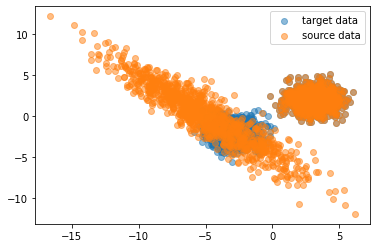

In [20]:
# A plot to compare targe and source data
plt.scatter(X_target[:, 0], X_target[:, 1], label = 'target data', alpha = 0.5)
plt.scatter(X_source[:, 0], X_source[:, 1], label = 'source data', alpha = 0.5)
plt.legend()

In [0]:
# Transforming the data into Pytorch format
data_source = pd.DataFrame({'X1' : X_source[:, 0].tolist(),
                   'X2' : X_source[:, 1].tolist(), 
                   'label' : y_target.tolist()})

In [0]:
source_dataset = CustomDataset(data_source, transform = None)
source_loader = torch.utils.data.DataLoader(source_dataset, batch_size = 16, shuffle = True, num_workers = 2)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class linear_model_new(nn.Module):
  def __init__(self):
    super(linear_model_new, self).__init__()
    self.fc1 = nn.Linear(2, 1)
    nn.init.xavier_normal_(self.fc1.weight)

  def forward(self, x):
    x = x.view(-1, 2)
    x1 = torch.sigmoid(self.fc1(x))  
    
    return x1
  
model_new = linear_model_new()  

In [0]:
# Define loss function and optimizer
import torch.optim as optim

loss_function_new = nn.BCELoss(reduction = 'mean') # sums all outputs and divides by total data points

optimizer_new = optim.Adam(model_new.parameters(), lr = 0.01)

In [25]:
# Define hyper-parameters before training
n_epochs = 4
a = torch.Tensor([1, -1])
mu_ = 1
for epochs in range(n_epochs):
 
  running_loss = 0
  
  for batch in source_loader:
    data, targets = batch

    optimizer_new.zero_grad()

    output = model_new(data.float()) 
    loss = loss_function_new(output, targets.view(-1, 1).float())
     #+ mu_ * torch.matmul(a.view(1, 2), model_new.fc1.weight.view(2, 1)) / torch.sqrt(torch.matmul(model_new.fc1.weight.view(1, 2), model_new.fc1.weight.view(2, 1)))
    
    loss.backward()

    optimizer_new.step()

    running_loss += loss.item()
  print(running_loss)

412.95298820734024
56.19408545643091
13.129475634545088
7.318331258371472


In [26]:
# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in target_loader:
    images, labels = data
    outputs = model_new(images.float())
#     _, predicted = torch.max(outputs, 1)
    predicted = outputs > 0.5
#     predicted = predicted.view(predicted.size(0))
    total += labels.size(0)
    matches = 0
    for i in range(len(predicted)):
      if predicted[i].item() == labels[i].item():
        matches += 1
    correct += matches#(predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

Accuracy of the network on the entire data set is : 100 %


In [27]:
model_new.fc1.weight

Parameter containing:
tensor([[0.6915, 0.6729]], requires_grad=True)

(-10.0, 10.0)

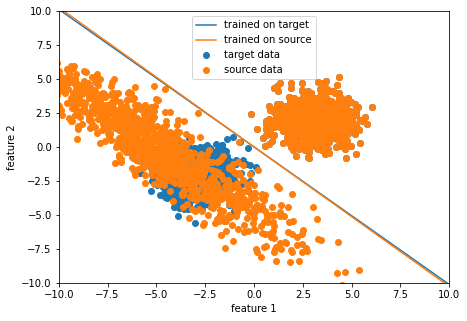

In [28]:
plt.figure(figsize = (7, 5))
x_s1 = list(range(-20, 25, 5))
y_s1 = []
y_s2 = []
for el in x_s1:
  y_s1.append((-model_new.fc1.weight[0][0].item()/ model_new.fc1.weight[0][1].item()) * el)
for el in x_s1:
  y_s2.append((-model.fc11.weight[0][0].item()/ model.fc11.weight[0][1].item()) * el)

plt.plot(x_s1, y_s2, label = 'trained on target') 
plt.plot(x_s1, y_s1, label = 'trained on source') 

plt.legend()
plt.scatter(data_target['X1'], data_target['X2'], label = 'target data')
plt.scatter(data_source['X1'], data_source['X2'], label = 'source data')
plt.legend()
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
